In [816]:
from forge import *

import cv2
import numpy as np
from IPython.display import display
from PIL import Image

from data import data

images = {
  'before': 'src/puzzle/examples/gph/y2019/before.png',
  'after': 'src/puzzle/examples/gph/y2019/after.png',
}

def get_image(src, scale=True):
  # download the image, convert it to a NumPy array, and then read
  # it into OpenCV format
  image = cv2.imread(data.project_path(src), flags=cv2.IMREAD_UNCHANGED)
  if scale:
    return image[::4, ::4, :3]
  return image

def enhance(img):
  kernel = np.ones((2, 2), np.uint8)
  return cv2.dilate(recolor(img), kernel, iterations=1)

_VALUE_MAP = {
  204: 64,
  221: 128,
  238: 192,
  255: 255,
}

def recolor(ndarray):
  result = ndarray.copy()
  for row, col in zip(*result[:,:,:1].nonzero()[:2]):
    for channel, value in enumerate(result[row][col]):
      try:
        result[row][col][channel] = _VALUE_MAP[value]
      except:
        pass
  return result

def show(img, should_enhance=True):
  if should_enhance:
    img = enhance(recolor(img))
  display(Image.fromarray(img))

def pt(x):
  a, b = x
  return b, a

WHITE = (255, 255, 255)


import collections
import heapq
import itertools

from typing import Generic, Iterable, Tuple, TypeVar

T = TypeVar('T')


class MinHeap(Generic[T]):
  def __init__(self) -> None:
    self._heap = []
    self._pool = []
    self._free_positions = []

  def __len__(self) -> int:
    return len(self._heap)

  def push(self, cost: float, o: T) -> None:
    if self._free_positions:
      idx = self._free_positions.pop()
      self._pool[idx] = o
    else:
      idx = len(self._pool)
      self._pool.append(o)
    heapq.heappush(self._heap, (cost, idx))

  def pop(self) -> Tuple[T, float]:
    weight, idx = heapq.heappop(self._heap)
    result = self._pool[idx]
    self._pool[idx] = None
    self._free_positions.append(idx)
    return result

  def magnitude(self) -> float:
    return self._heap[0][0]
  
  def __repr__(self) -> str:
    return 'MinHeap(%s)' % repr(self._heap)
  
  __str__ = __repr__


def calculate_distances(before, after):
  distances = MinHeap()
  # TODO: Consider luminosity and color too.
  for pair in itertools.product(zip(*before.nonzero()[:2]), zip(*after.nonzero()[:2])):
    a, b = pair
    ax, ay = a
    bx, by = b
    dist = (bx - ax)**2 + (by - ay)**2
    distances.push(dist, pair)
  return distances

def draw_closest_greedy(before, after, distance_heap):
  kernel = np.ones((3, 3), np.uint8)
  result = cv2.dilate(after, kernel, iterations=1)
  before_seen = set()
  after_seen = set()
  while distance_heap:
    before_pt, after_pt = distance_heap.pop()
    if before_pt in before_seen or after_pt in after_seen:
      continue
    before_seen.add(before_pt)
    after_seen.add(after_pt)
    row, col = after_pt
    r, g, b = after[row][col]
    #print(before_pt, after_pt, (int(r), int(g), int(b)), 1)
    cv2.line(result, before_pt[::-1], after_pt[::-1], (int(r), int(g), int(b)), 1)
  return result

def isolate_colors(changed):
  result = {}
  for row, col in zip(*changed[:,:,:1].nonzero()[:2]):
    color = changed[row][col]
    key = tuple(color)
    if key not in result:
      result[key] = np.zeros_like(changed)
    isolate = result[key]
    isolate[row][col] = color
  return result

def iter_nonzero(ndarray):
  return zip(*ndarray[:,:,:1].nonzero()[:2])


import collections

def centers(ndarray, labels=None):
  result = np.zeros_like(ndarray)

  center_x = collections.defaultdict(list)
  center_y = collections.defaultdict(list)
  for row, col in iter_nonzero(ndarray):
    color = tuple(ndarray[row][col])
    center_x[color].append(col)
    center_y[color].append(row)
  for color in center_x:
    cx = int(sum(center_x[color]) / len(center_x[color]))
    cy = int(sum(center_y[color]) / len(center_y[color]))
    r, g, b = color
    if labels:
      cv2.putText(result, labels[color], (cx, cy), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (int(r), int(g), int(b)))
    else:
      cv2.circle(result, (cx, cy), 4, (int(r), int(g), int(b)))
  return result

In [792]:
before = get_image(images['before'])
after = get_image(images['after'])
ret, before = cv2.threshold(before, 127, 255, cv2.THRESH_TOZERO)
ret, after = cv2.threshold(after, 127, 255, cv2.THRESH_TOZERO)

In [596]:
same = np.all([before, after], axis=0)
changed_after = np.where(same, 0, after)
changed_before = np.where(same, 0, before)

In [177]:
np.count_nonzero(np.all([before, after], axis=0)[:,:,:1])

41

123


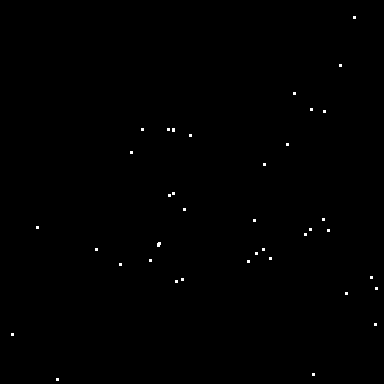

In [517]:
unchanged = np.where(same, after, 0)
print(np.count_nonzero(unchanged))
show(unchanged)

In [8]:
def coords(changed):
  colors = {}
  for y, row in enumerate(changed):
    for x, col in enumerate(row):
      if col[0]:
        r, g, b = col
        combined = r << 16 | r << 8 | b
        name = colors.setdefault(combined, chr(ord('A') + len(colors)))
        print(f'{x}\t{y}\t#{combined:0{6}x}\t{name}'.upper())
print('before')
coords(changed_before)
print('after')
coords(changed_after)

before
245	9	#FFFFFF	A
30	20	#FFFFFF	A
311	29	#FFFFFF	A
187	36	#FFFFFF	A
169	39	#FFFFFF	A
26	58	#FFFFFF	A
74	60	#FFFFFF	A
270	77	#FFFFFF	A
295	83	#FFFFFF	A
263	85	#FFFFFF	A
154	98	#FFFFFF	A
98	101	#FFFFFF	A
207	110	#FFFFFF	A
4	114	#FFFFFF	A
102	126	#FFFFFF	A
262	127	#FFFFFF	A
210	137	#FFFFFF	A
55	139	#FFFFFF	A
98	140	#FFFFFF	A
23	160	#FFFFFF	A
343	164	#FFFFFF	A
139	167	#FFFFFF	A
99	183	#FFFFFF	A
285	185	#FFFFFF	A
235	188	#FFFFFF	A
50	190	#FFFFFF	A
327	198	#FFFFFF	A
356	199	#FFFFFF	A
278	214	#FFFFFF	A
12	221	#FFFFFF	A
91	222	#FFFFFF	A
241	226	#FFFFFF	A
116	234	#FFFFFF	A
380	234	#FFFFFF	A
136	244	#FFFFFF	A
190	245	#FFFFFF	A
43	255	#FFFFFF	A
50	289	#FFFFFF	A
218	299	#FFFFFF	A
292	299	#FFFFFF	A
174	302	#FFFFFF	A
146	304	#FFFFFF	A
309	313	#FFFFFF	A
98	338	#FFFFFF	A
229	345	#FFFFFF	A
after
90	50	#CCCCFF	A
178	61	#CCCCEE	B
193	63	#CCCCEE	B
113	72	#CCCCFF	A
255	75	#CCCCDD	C
292	78	#CCCCDD	C
93	79	#CCCCFF	A
78	91	#CCCCFF	A
208	91	#CCCCEE	B
275	102	#CCCCDD	C
66	104	#DDDDEE	D
224	105	#CCCCDD	C
21

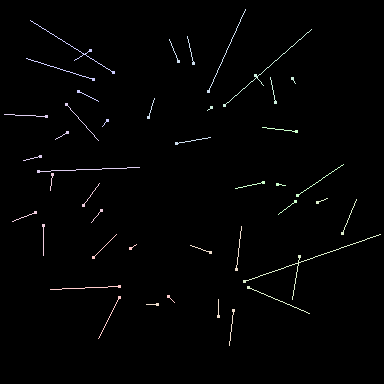

In [180]:
distances = calculate_distances(changed_before, changed_after)

show(draw_closest_greedy(changed_before, changed_after, distances))

In [181]:
import math

def angle_sort(data):
  results = []
  height, width, depth = data.shape
  center_x = width / 2
  center_y = height / 2
  for y, row in enumerate(data):
    for x, col in enumerate(row):
      cx = x - center_x
      cy = y - center_y
      if col[0]:
        results.append((math.degrees(math.atan2(cy, cx)) % 360, x, y, col))
  return sorted(results, key=lambda x: x[0])

before_angles = angle_sort(changed_before)
after_angles = angle_sort(changed_after)

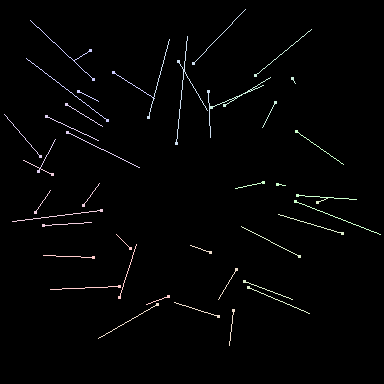

In [182]:
def motion(changed, before_angles, after_angles):
  kernel = np.ones((3, 3), np.uint8)
  result = cv2.dilate(changed, kernel, iterations=1)
  for (before_d, before_x, before_y, _), (after_d, after_x, after_y, (r, g, b)) in zip(before_angles, after_angles):
    cv2.line(result, (before_x, before_y), (after_x, after_y), (int(r), int(g), int(b)), 1)
  return result

show(motion(changed_after, before_angles, after_angles))


In [810]:
import collections

def centers(ndarray):
  kernel = np.ones((3, 3), np.uint8)
  result = np.zeros_like(ndarray)

  center_x = collections.defaultdict(list)
  center_y = collections.defaultdict(list)
  for row, col in iter_nonzero(ndarray):
    key = tuple(ndarray[row][col])
    center_x[key].append(col)
    center_y[key].append(row)
  for color in center_x:
    cx = int(sum(center_x[color]) / len(center_x[color]))
    cy = int(sum(center_y[color]) / len(center_y[color]))
    r, g, b = color
    cv2.circle(result, (cx, cy), 4, (int(r), int(g), int(b)))
  return result

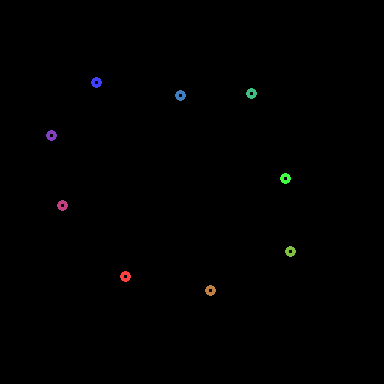

In [811]:
show(centers(changed_after))

In [215]:
a = np.array([
  [[1, 1], [2, 2], [3, 3]],
  [[0, 0], [4, 4], [6, 6]],
])
for row, col in zip(*a[:,:,:1].nonzero()[:2]):
  print(row, col)


0 0
0 1
0 2
1 1
1 2


In [214]:
a[:,:,:1].nonzero()[:2]

(array([0, 0, 0, 1, 1]), array([0, 1, 2, 1, 2]))

45
45


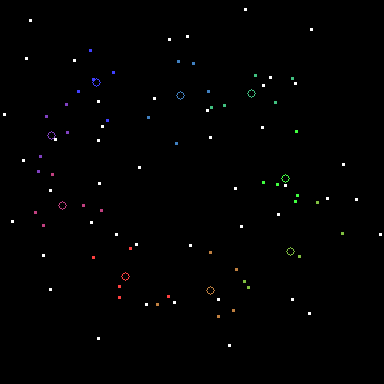

In [229]:
kernel = np.ones((3, 3), np.uint8)
show(cv2.dilate(changed_before, kernel, iterations=1) + centers(recolor(changed_after)))

In [285]:
unchanged = np.where(same, after, 0)
SEARCH_BOX = 1

def find_unchanged_destination(unchanged, before, after):
  kernel = np.ones((3, 3), np.uint8)
  result = cv2.dilate(after, kernel, iterations=1)
  rows, cols = unchanged.shape[:2]
  
  before_found_counts = collections.defaultdict(int)
  after_found_counts = collections.defaultdict(int)
  
  for pair in itertools.product(zip(*before.nonzero()[:2]), zip(*after.nonzero()[:2])):
    b, a = pair
    b_row, b_col = b  # Before.
    a_row, a_col = a  # After.
    d_row = a_row - b_row  # Delta row.
    d_col = a_col - b_col  # Delta col.
    e_row = b_row + 2 * d_row
    e_col = b_col + 2 * d_col
    found = 0
    if 0 < e_row < rows and 0 < e_col < cols:
      for row_offset in range(-SEARCH_BOX + 1, SEARCH_BOX):
        for col_offset in range(-SEARCH_BOX + 1, SEARCH_BOX):
          end = unchanged[(e_row+row_offset) % rows][(e_col+col_offset) % cols]
          if end[0]:
            print(b, a, end, row_offset, col_offset)
            found += 1
    if found:
      before_found_counts[b] += 1
      after_found_counts[a] += 1
  return before_found_counts, after_found_counts


In [286]:
find_unchanged_destination(unchanged, changed_before, changed_after)

(221, 12) (143, 176) [255 255 255] 0 0
(221, 12) (143, 176) [255 255 255] 0 0
(221, 12) (143, 176) [255 255 255] 0 0
(221, 12) (143, 176) [255 255 255] 0 0
(221, 12) (143, 176) [255 255 255] 0 0
(221, 12) (143, 176) [255 255 255] 0 0
(221, 12) (143, 176) [255 255 255] 0 0
(221, 12) (143, 176) [255 255 255] 0 0
(221, 12) (143, 176) [255 255 255] 0 0


(defaultdict(int, {(221, 12): 9}), defaultdict(int, {(143, 176): 9}))

In [407]:
isolated = isolate_colors(changed_after)

In [408]:
isolated.keys()

dict_keys([(204, 204, 255), (204, 221, 238), (204, 238, 221), (221, 204, 238), (204, 255, 204), (238, 204, 221), (221, 238, 204), (255, 204, 204), (238, 221, 204)])

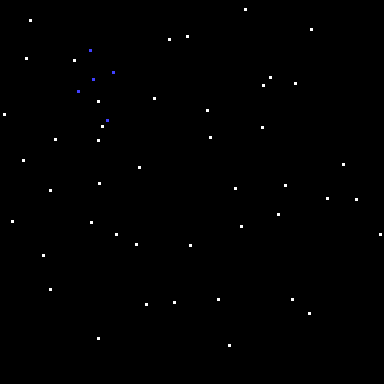

In [410]:
show(isolated[(204, 204, 255)] + changed_before)

In [860]:
def compare_angles(*args, validate=False):   
  slopes = []
  for a, b in itertools.combinations(args, 2):
    a_row, a_col = a
    b_row, b_col = b
    dx = abs(b_col - a_col)
    dy = abs(b_row - a_row)
    slopes.append(360 + (math.degrees(math.atan2(dy, dx)) % 360))
  avg = sum(slopes) / len(slopes)
  return sum(abs(slope - avg) for slope in slopes)

def colinear(before, cluster, banned, validate=True):
  results = collections.defaultdict(MinHeap)
  for target in iter_nonzero(cluster):
    for a, b in itertools.product(iter_nonzero(before), iter_nonzero(before)):
      if a == b or a in banned or b in banned:
        continue
      if validate:
        t_row, t_col = target
        a_row, a_col = a
        b_row, b_col = b
        dra = t_row - a_row
        drb = b_row - t_row
        if (dra <= 0) != (drb <= 0):
          continue
        dca = t_col - a_col
        dcb = b_col - t_col
        if (dca <= 0) != (dcb <= 0):
          continue
      results[target].push(compare_angles(target, a, b), (a, b))
  return results

def filter_chains(collinear_data):
  # Only keep points seen 2+ times.
  counts = collections.defaultdict(set)
  all_pairs = collections.defaultdict(list)
  for target, collinear_points in collinear_data.items():
    while collinear_points:
      weight = collinear_points.magnitude()
      top = collinear_points.pop()
      if weight > 10:
        continue
      a, b = top
      counts[a].add(target)
      counts[b].add(target)
      all_pairs[target].append((weight, top))
  # Filter list.
#   for target, pairs in all_pairs.items():
#     filtered = []
#     for weight, pair in pairs:
#       a, b = pair
#       if len(counts[a]) >= 2 and len(counts[b]) >= 2:
#         filtered.append((weight, pair))
#     all_pairs[target] = filtered
  # Build a map of a<->b.
  graph = collections.defaultdict(list)
  for target, pairs in all_pairs.items():
    for weight, pair in pairs:
      a, b = pair
      graph[a].append((target, b))
      graph[b].append((target, a))
  cycle = cyclic(graph)
  if cycle:
    return cycle
    # Filter list again.
    for target, pairs in all_pairs.items():
      filtered = []
      for weight, pair in pairs:
        a, b = pair
        if a in cycle and b in cycle:
          filtered.append((weight, pair))
      if filtered:
        all_pairs[target] = filtered
  # Restore data.
  for target, pairs in all_pairs.items():
    for weight, pair in pairs:
      collinear_data[target].push(weight, pair)
  return collinear_data

def cyclic(g):
    path = set()
    targets = {}
    first = None  # Set in loop below

    def visit(vertex):
        path.add(vertex)
        if len(path) > 5:
          path.remove(vertex)
          return False
        for target, neighbor in g.get(vertex, ()):
          if target not in targets:
            targets[target] = (vertex, neighbor)
            if neighbor == first and len(path) == 5 and len(targets) == 5:
              return True
            elif neighbor not in path:
              if visit(neighbor):
                return True
            del targets[target]
        path.remove(vertex)
        return False
    for first in g:
      if visit(first):
        return targets

import math      

def extract(a, b, c):
  ref = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  fer = ''.join(reversed(ref))
  ref += '#'
  fer += '#'
  size = len(ref)
  ay, ax = a
  cy, cx = c
  total = math.sqrt((cx - ax)**2 + (cy - ay)**2)
  result = []
  for i, j in ((a, b),): #, (b, c)):
    iy, ix = i
    jy, jx = j
    delta = math.sqrt((jx - ix)**2 + (jy - iy)**2)
    #result.append(ref[int(round(size * delta / total))])
    result.append(ref[round(size * delta / total) - 1])  # For 27.
    #result.append(ref[int(round(size * delta / total))])
    #result.append(ref[size - int(round(size * delta / total))])
    #result.append(fer[round(size * delta / total) - 1])  # For 27.
    #result.append(fer[int(round(size * delta / total))])
  return result

def draw_colinear(img, colinear_data, visited, reverse):
  result = np.copy(img)
  dim_step = .18
  letters = []
  last = None
  items = list(colinear_data.items())
  if reverse:
    items = list(reversed(items))
  for i, (target, (first, second)) in enumerate(items):
    if reverse:
      first, second = second, first
    visited.add(first)
    visited.add(second)
    r, g, b = img[target]
    r, g, b = int(r), int(g), int(b)
    letter = extract(first, target, second)
    letters.append(letter)
    if False:
      text = str(i + 1)
    else:
      text = letter[0]
    if not last:
      last = first
      cv2.putText(result, text, pt(first), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.75, (r, g, b))
    else:
      if first != last:
        print('swapped', first, second, 'expected', first, '=', last)
        second, first = first, second
      cv2.putText(result, text, pt(first), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.75, (r, g, b))
    last = second
    dim = 1 - (i * dim_step)
    cv2.line(result, pt(first), pt(second), (int(r * dim), int(g * dim), int(b * dim)))
    result[target] = (b, r, g)
    result[first] = WHITE
    result[second] = WHITE
  print(set(map(''.join, zip(*letters))))
  return result


(204, 204, 255) False
{'RMLYI'}


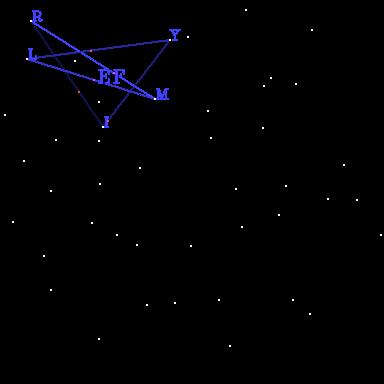

(204, 238, 221) True
{'YVATL'}


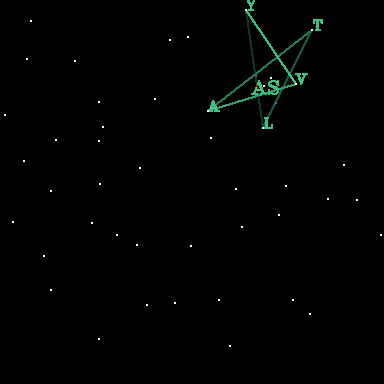

(204, 255, 204) False
{'LIGTF'}


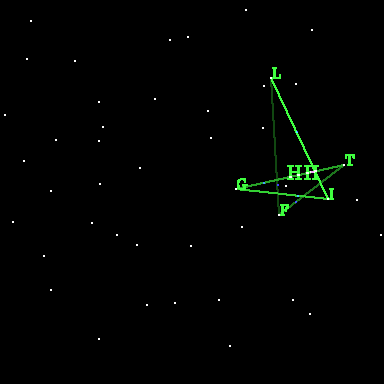

(221, 238, 204) False
{'HLIVE'}


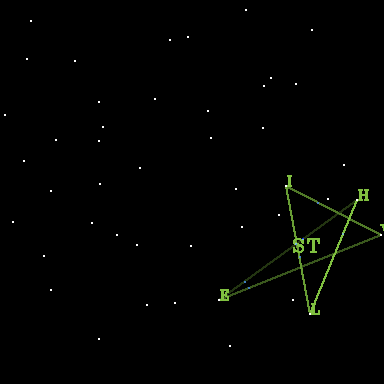

(238, 221, 204) True
{'SHLYR'}


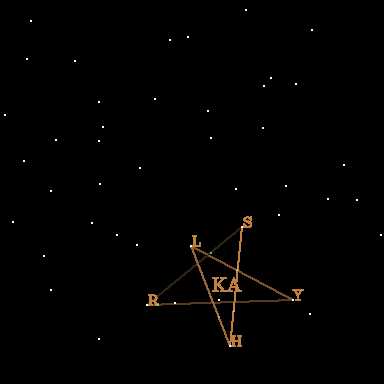

(204, 221, 238) True
{'GORSV'}


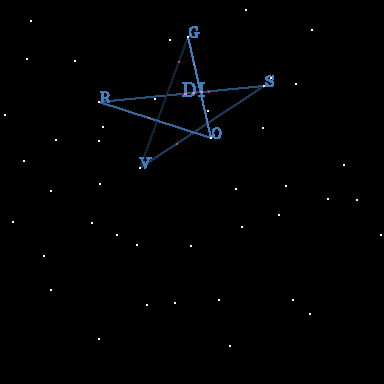

(238, 204, 221) True
{'TSGHS'}


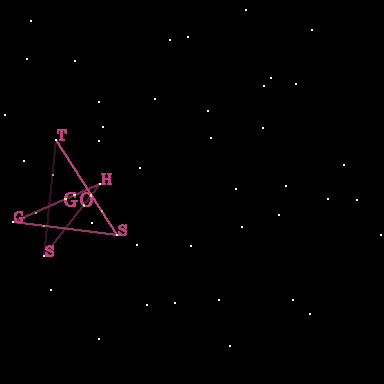

(221, 204, 238) False
{'IGRUL'}


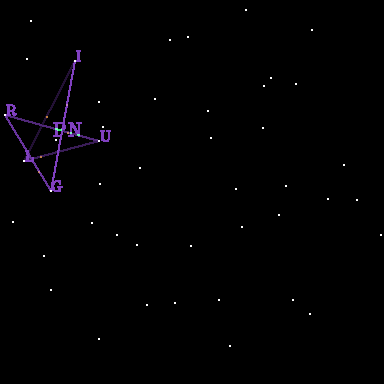

(255, 204, 204) True
{'LSYLY'}


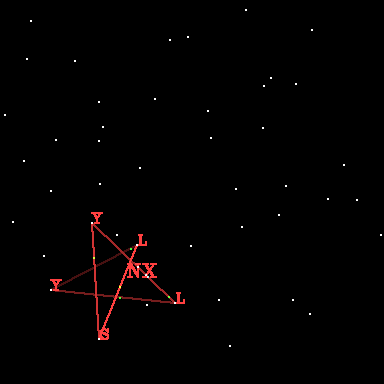

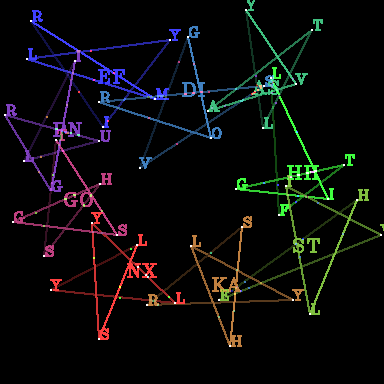

In [872]:
visit_order = [
  # Good.
  (204, 204, 255),
  (204, 238, 221),
  (204, 255, 204),
  (221, 238, 204),
  (238, 221, 204),
  
  # Bad.
  (204, 221, 238),
  (238, 204, 221),
  (221, 204, 238),
  (255, 204, 204),
]

# parabling paraphing pedalling penancing petalling petarding phialling pleaching potashing preaching preacting prearming preassing proacting
COUNTER_CLOCKWISE_LETTERS = {
  (204, 204, 255): 'BONI(E)R',
  (204, 221, 238): 'HILTE(D)',
  (204, 238, 221): 'G(A)ZEBO',  # A
  (204, 255, 204): 'TROUG(H)',  # H
  (221, 238, 204): 'VER(S)OS',
  (238, 221, 204): '(K)IBOSH',  # K
  (255, 204, 204): 'HOB(N)OB',  # N
  (238, 204, 221): 'THI(G)HS',  # G
  (221, 204, 238): '(P)ROFIT',  # P
}

CLOCKWISE_LETTERS = {
  (204, 204, 255): '(F)IRMLY',
  (204, 221, 238): 'V(I)GORS',
  (204, 238, 221): 'VA(S)TLY',
  (204, 255, 204): 'FLIG(H)T',
  (221, 238, 204): 'LIVE(T)H',
  (238, 221, 204): 'R(A)SHLY',
  (255, 204, 204): '(X)YLYLS',
  (238, 204, 221): 'GH(O)STS',
  (221, 204, 238): 'RULI(N)G',
}
MERGED_LETTERS = {
  (204, 204, 255): 'EF',
  (204, 221, 238): 'DI',
  (204, 238, 221): 'AS',
  (204, 255, 204): 'HH',
  (221, 238, 204): 'ST',
  (238, 221, 204): 'KA',
  (255, 204, 204): 'NX',
  (238, 204, 221): 'GO',
  (221, 204, 238): 'PN',
}

TEND_CLOCKWISE = {
  (204, 204, 255),
  (204, 255, 204),
  (221, 238, 204),
  (221, 204, 238),
}

combined = None
visited = set()
want_clockwise = True
for color in visit_order:
  reverse = False
  if want_clockwise:
    letters = CLOCKWISE_LETTERS
    if color not in TEND_CLOCKWISE:
      reverse = True
  else:
    letters = COUNTER_CLOCKWISE_LETTERS
    if color in TEND_CLOCKWISE:
      reverse = True
  letters = MERGED_LETTERS
  print(color, color not in TEND_CLOCKWISE)
  colinear_data = filter_chains(colinear(changed_before, isolated[color], visited))
  drawn = draw_colinear(
    recolor(isolated[color]),
    colinear_data,
    visited,
    reverse,
  ) + centers(isolated[color], letters)
  #if color in good:
  if combined is None:
    combined = drawn
  else:
    combined += drawn
  show(drawn + changed_before)

if combined is not None:
  show(combined + changed_before)

In [863]:
changed_after[(50, 90)]

array([204, 204, 255], dtype=uint8)

In [ ]:
itertools.product(zip(*changed_before[:,:,:1].nonzero()[:2]), zip(*before[:,:,:1].nonzero()[:2]))

In [449]:
changed_before[:,:,:1].nonzero()

(array([  9,  20,  29,  36,  39,  58,  60,  77,  83,  85,  98, 101, 110,
        114, 126, 127, 137, 139, 140, 160, 164, 167, 183, 185, 188, 190,
        198, 199, 214, 221, 222, 226, 234, 234, 244, 245, 255, 289, 299,
        299, 302, 304, 313, 338, 345]),
 array([245,  30, 311, 187, 169,  26,  74, 270, 295, 263, 154,  98, 207,
          4, 102, 262, 210,  55,  98,  23, 343, 139,  99, 285, 235,  50,
        327, 356, 278,  12,  91, 241, 116, 380, 136, 190,  43,  50, 218,
        292, 174, 146, 309,  98, 229]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [484]:
lines = [
  ((43, 255), (90, 50)),
  ((309, 313), (113, 72)),
  ((99, 183), (93, 79)),
  ((50, 190), (78, 91)),
  ((146, 304), (107, 120)),
]
dest = (91, 45)

In [487]:
def draw_lines(img, lines, dest):
  r, g, b = (204, 204, 255)
  result = np.copy(img)
  dim = 0.5
  for before, after in lines:
    print(before, after, (int(r * dim), int(g * dim), int(b * dim)))
    cv2.line(result, before, after, (int(r * dim), int(g * dim), int(b * dim)))
  cv2.circle(result, dest, 4, (int(r), int(g), int(b)))
  return result + img

(43, 255) (90, 50) (102, 102, 127)
(309, 313) (113, 72) (102, 102, 127)
(99, 183) (93, 79) (102, 102, 127)
(50, 190) (78, 91) (102, 102, 127)
(146, 304) (107, 120) (102, 102, 127)


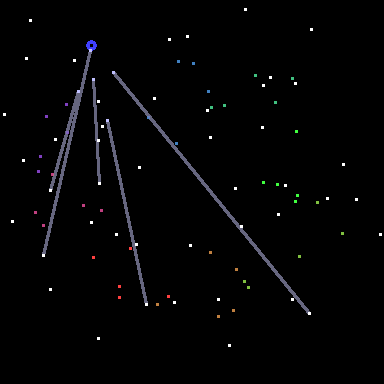

In [490]:
show(draw_lines(changed_before, lines, dest) | changed_after | changed_before)

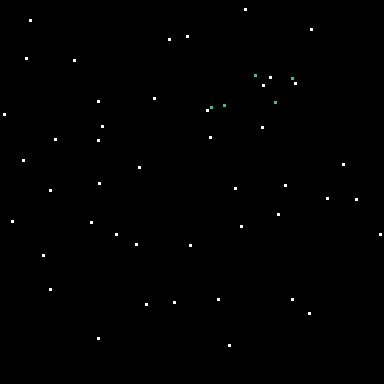

In [492]:
show(isolated[(204, 238, 221)] | changed_before)

In [767]:
extract((0, 0), (24.9, 24.9), (25, 25))

['Z', 'Y', 'A', 'B', 'A', 'A', 'Z', 'Z']